In [149]:
from typing import Literal

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer

from joblib import dump, load

import pandas as pd
import matplotlib.pyplot as plt

In [151]:
base_df = pd.read_csv('/content/STORM_preprocessed_medianfill_1.csv')

In [152]:
LINEAR_TARGETS = ["TotalDeaths", "NoInjured", "TotalDamageAdjusted(000US$)"]
CATEGORICAL_TARGETS = ['Flood', 'Slide']
ATTRIBUTES = ['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']

In [153]:
#from src.const import DATA_HEAD, WEIGHTS_HEAD
from const import WEIGHTS_HEAD, DATA_HEAD

data_filename = "STORM_preprocessed_medianfill_1.csv"
base_df = pd.read_csv(str(data_filename), index_col=0)
base_df.head()

,ID,EventName,Year,Month,DisasterType,DisasterSubtype,MainLandfallLocation,Flood,Slide,OFDAResponse,Appeal,Declaration,LandfallMagnitude(kph),LandfallPressure(mb),TotalDeaths,NoInjured,TotalDamage(000US$),TotalDamageAdjusted(000US$),CPI
0,STORM_NAN_1953,NaN,1953,9,Storm,Tropical cyclone,8,0,0,0,0,0,92,989,1000,20,19400,211880,9.156133
1,STORM_VIOLET_1964,Violet,1964,9,Storm,Tropical cyclone,4,1,1,0,0,0,92,989,18,20,10000,94354,10.598376
2,STORM_IRIS_1964,Iris,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,150,960,5100,20,70000,660479,10.598376
3,STORM_JOAN_1964,Joan,1964,11,Storm,Tropical cyclone,5,1,0,0,0,0,130,980,2500,20,15000,141531,10.598376
4,STORM_KATE_1964,Kate,1964,11,Storm,Tropical cyclone,6,1,0,0,0,0,130,970,0,20,3000,28306,10.598376


# Featue importance

target: death, injure, total dmg adjust . metric: mse, terminate the large error in predict dmg, phu hop voi gbms


| **Mô hình**               | **Ưu điểm**                            | **Nhược điểm**                          | **Khi nào dùng?**                       |
|---------------------------|----------------------------------------|-----------------------------------------|----------------------------------------|
| XGBoost                   | Hiệu quả cao, chống overfitting        | Tốn tài nguyên, huấn luyện chậm         | Dữ liệu lớn, nhiều tính năng                   |
| LightGBM                  | Nhanh, hiệu quả trên dữ liệu lớn       | Thiếu chính xác với dữ liệu nhỏ         | Dữ liệu lớn, cần tốc độ        |
| CatBoost                  | Tốt cho dữ liệu phân loại              | Cần nhiều tài nguyên                    | Khi có nhiều tính năng phân loại                       |
| AdaBoost                  | Đơn giản, dễ triển khai                | Hiệu suất kém hơn các GBM khác          | Dữ liệu nhỏ, ít biến động                       |
| Decision Trees (GBDT)     | Dự đoán chính xác với dữ liệu phi tuyến| Chậm khi số lượng cây lớn               | Dữ liệu phi tuyến, phức tạp                     |
| NGBoost                   | Mô hình hóa phân phối xác suất         | Phức tạp hơn, ít phổ biến               | Khi cần dự đoán phân phối xác suất                   |

**Model selection**
1. `XGBoost`
   - XGBoost is highly effective for data that contains both linear and non-linear relationships.
   - It is suitable for datasets with many features, where overfitting might be a concern. XGBoost provides robust feature importance, making it ideal for understanding key factors in complex datasets.
2. `LightGBM`
   - LightGBM is a fast and efficient model that is particularly effective on datasets with a large number of features.
   - It is suitable when quick training is required without sacrificing performance, making it a strong option when speed is prioritized and feature importance needs to be calculated quickly.
3. `CatBoost`
   - CatBoost is designed to handle datasets with many categorical variables without the need for extensive preprocessing, such as one-hot encoding.
   - It is particularly useful when working with datasets that contain mixed feature types (numerical and categorical) and when minimal data preprocessing is desired, while still delivering accurate feature importance.
4. `Decision Trees (GBDT)`
   - Decision Trees (GBDT) are effective at capturing complex, non-linear patterns in data.
   - It is suitable for datasets with non-linear relationships and complex interactions between features, especially when the goal is to model accurate predictions while identifying the most important features contributing to those predictions.

# 1. PREDICT LINEAR_TARGET


## 1.1.  No Death

In [174]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[0]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :TotalDeaths
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.1.1 XGBOOST

In [175]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [176]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


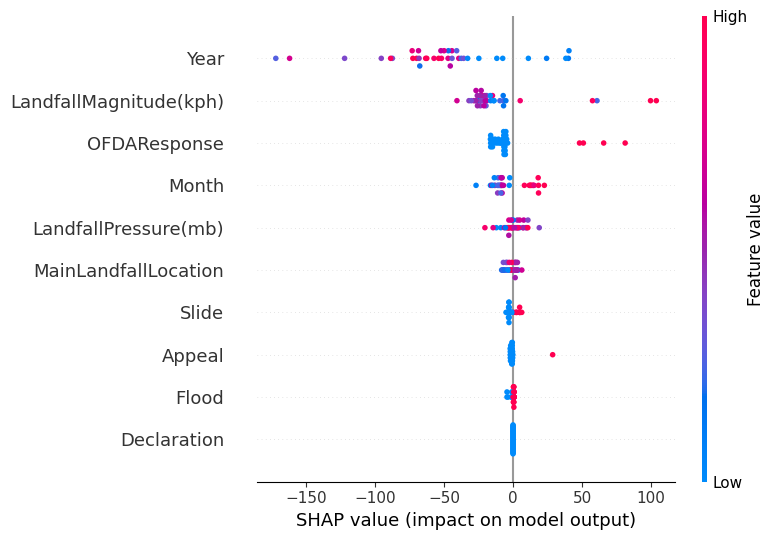

In [177]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.2 LightGBM

In [178]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [180]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


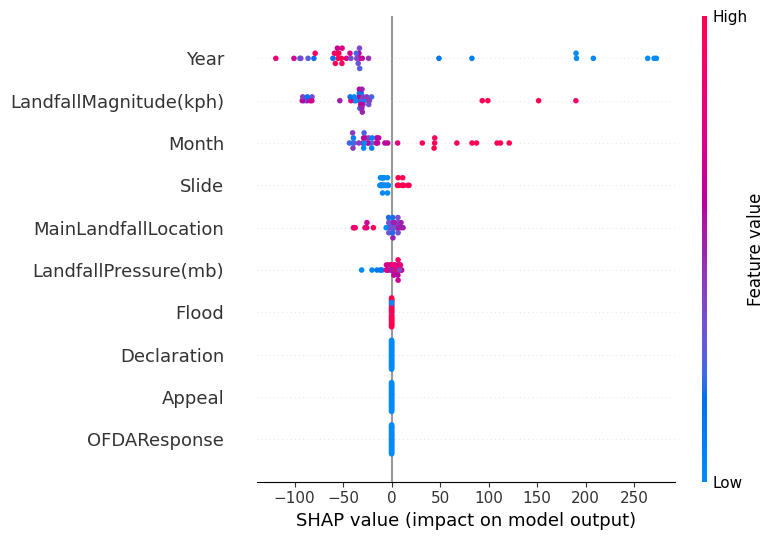

In [181]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.3 CatBoost

In [182]:
# !pip install catboost

In [183]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 1.19ms	remaining: 1.19s
1:	learn: 471.3640040	total: 5.13ms	remaining: 2.56s
2:	learn: 468.0167703	total: 6.36ms	remaining: 2.11s
3:	learn: 464.5655498	total: 8.03ms	remaining: 2s
4:	learn: 461.0471589	total: 8.81ms	remaining: 1.75s
5:	learn: 457.8991406	total: 9.68ms	remaining: 1.6s
6:	learn: 454.6768441	total: 10.2ms	remaining: 1.44s
7:	learn: 451.5365131	total: 10.6ms	remaining: 1.32s
8:	learn: 448.4834973	total: 14ms	remaining: 1.54s
9:	learn: 445.1840673	total: 15ms	remaining: 1.49s
10:	learn: 441.9371963	total: 16.3ms	remaining: 1.47s
11:	learn: 438.6976759	total: 17.8ms	remaining: 1.46s
12:	learn: 435.4896915	total: 18.5ms	remaining: 1.4s
13:	learn: 432.2595625	total: 19ms	remaining: 1.33s
14:	learn: 429.0760846	total: 19.4ms	remaining: 1.27s
15:	learn: 426.1680837	total: 19.8ms	remaining: 1.21s
16:	learn: 423.0339016	total: 20.1ms	remaining: 1.16s
17:	learn: 419.9474727	total: 20.4ms	remaining: 1.11s
18:	learn: 416.8331

In [184]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


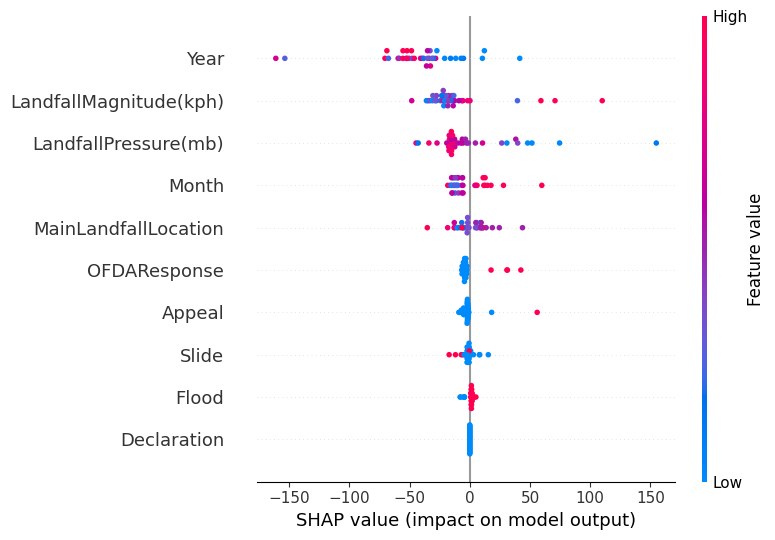

In [185]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.1.4 Decision Trees (GBDT)

In [186]:
from sklearn.ensemble import GradientBoostingRegressor  # GBDT từ scikit-learn
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [187]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.411485
7    LandfallPressure(mb)    0.259076
6  LandfallMagnitude(kph)    0.219274
2    MainLandfallLocation    0.051379
1                   Month    0.031920
9                   Slide    0.019042
3            OFDAResponse    0.003387
4                  Appeal    0.003110
8                   Flood    0.001328
5             Declaration    0.000000


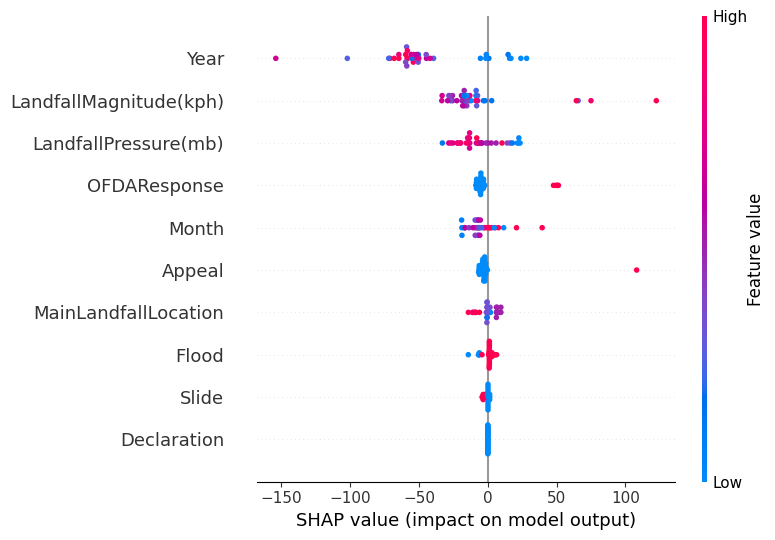

In [188]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.1.5 COMPARISION

In [191]:
# Chuẩn hóa độ quan trọng
def normalize_importance(df):
    df['Importance'] = (df['Importance'] - df['Importance'].min()) / (df['Importance'].max() - df['Importance'].min())
    return df

xgb_importance_df = normalize_importance(xgb_importance_df)
lgb_importance_df = normalize_importance(lgb_importance_df)
cat_importance_df = normalize_importance(cat_importance_df)
gbdt_importance_df = normalize_importance(gbdt_importance_df)

In [192]:
combined_importance = pd.concat([
    xgb_importance_df.set_index('Feature').rename(columns={'Importance': 'XGBoost'}),
    lgb_importance_df.set_index('Feature').rename(columns={'Importance': 'LightGBM'}),
    cat_importance_df.set_index('Feature').rename(columns={'Importance': 'CatBoost'}),
    gbdt_importance_df.set_index('Feature').rename(columns={'Importance': 'GBDT'})
], axis=1)

# Thay thế NaN bằng 0
combined_importance = combined_importance.fillna(0)

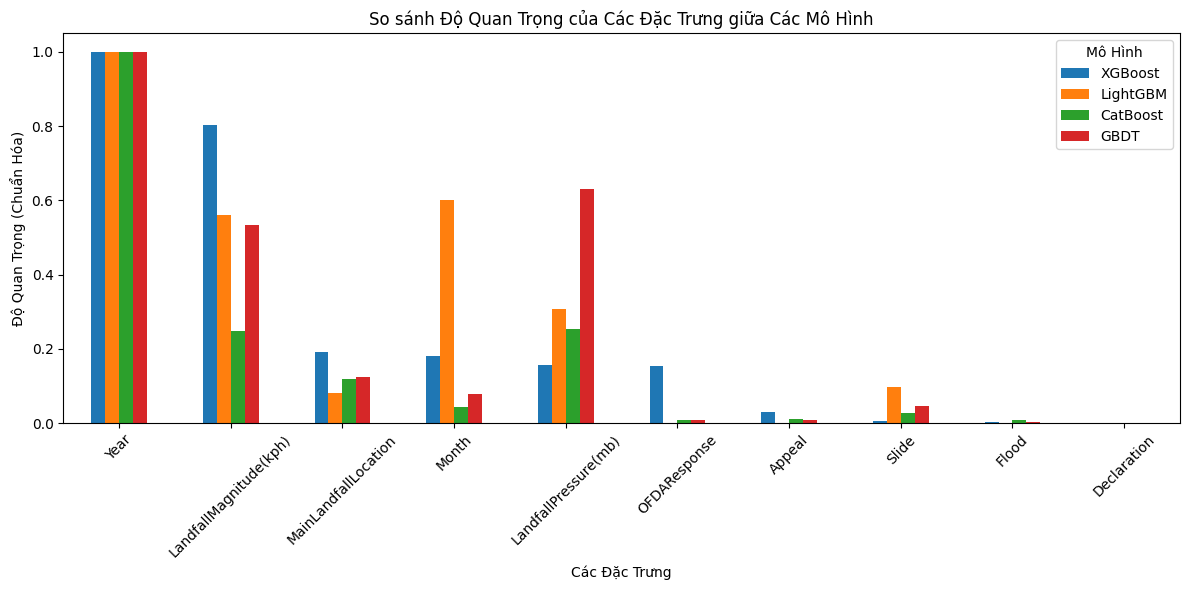

In [193]:
combined_importance.plot(kind='bar', figsize=(12, 6))
plt.title('So sánh Độ Quan Trọng của Các Đặc Trưng giữa Các Mô Hình')
plt.ylabel('Độ Quan Trọng (Chuẩn Hóa)')
plt.xlabel('Các Đặc Trưng')
plt.legend(title='Mô Hình')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.2.  No Injured

In [194]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[1]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :NoInjured
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.2.1 XGBOOST

In [195]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [197]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


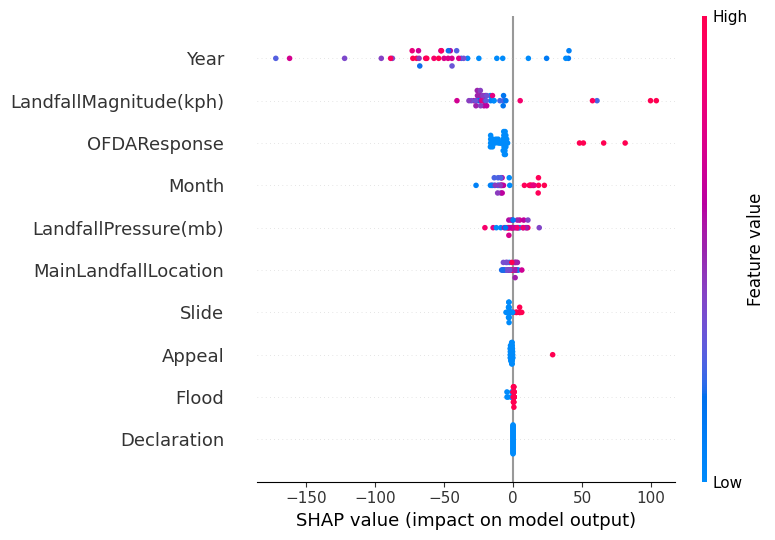

In [198]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.2.2 LightGBM

In [199]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [202]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


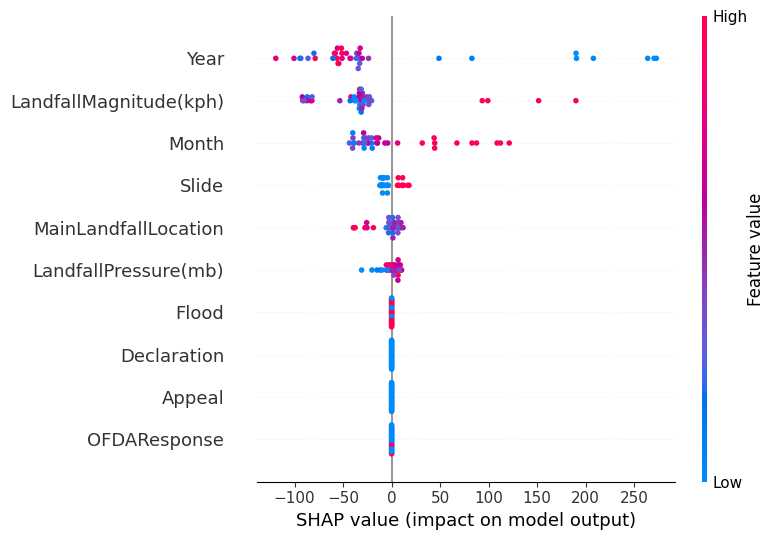

In [203]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.2.3 CatBoost

In [107]:
# !pip install catboost

In [205]:
from catboost import CatBoostRegressor
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 1.3ms	remaining: 1.29s
1:	learn: 471.3640040	total: 4.96ms	remaining: 2.48s
2:	learn: 468.0167703	total: 7.39ms	remaining: 2.46s
3:	learn: 464.5655498	total: 7.95ms	remaining: 1.98s
4:	learn: 461.0471589	total: 8.32ms	remaining: 1.66s
5:	learn: 457.8991406	total: 8.73ms	remaining: 1.45s
6:	learn: 454.6768441	total: 9.09ms	remaining: 1.29s
7:	learn: 451.5365131	total: 9.44ms	remaining: 1.17s
8:	learn: 448.4834973	total: 9.82ms	remaining: 1.08s
9:	learn: 445.1840673	total: 10.2ms	remaining: 1.01s
10:	learn: 441.9371963	total: 10.6ms	remaining: 950ms
11:	learn: 438.6976759	total: 11.1ms	remaining: 917ms
12:	learn: 435.4896915	total: 11.5ms	remaining: 875ms
13:	learn: 432.2595625	total: 11.9ms	remaining: 839ms
14:	learn: 429.0760846	total: 12.2ms	remaining: 804ms
15:	learn: 426.1680837	total: 12.6ms	remaining: 778ms
16:	learn: 423.0339016	total: 13.1ms	remaining: 756ms
17:	learn: 419.9474727	total: 13.4ms	remaining: 733ms
18:	learn

In [206]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


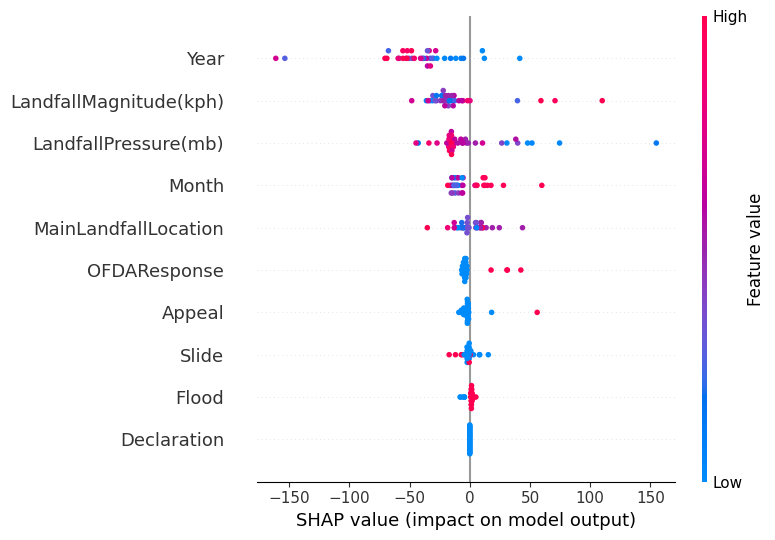

In [207]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.2.4 Decision Trees (GBDT)

In [208]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [210]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.412062
6  LandfallMagnitude(kph)    0.271489
7    LandfallPressure(mb)    0.212201
2    MainLandfallLocation    0.039203
9                   Slide    0.032914
1                   Month    0.024634
3            OFDAResponse    0.003465
4                  Appeal    0.003032
8                   Flood    0.000999
5             Declaration    0.000000


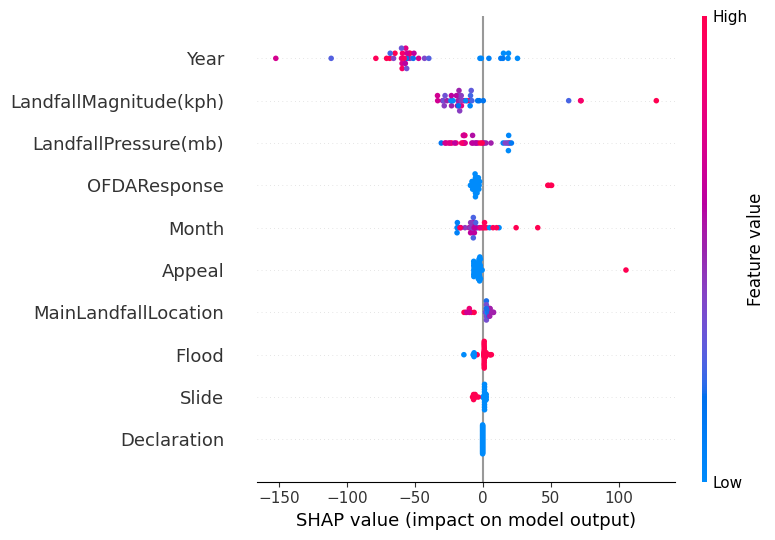

In [211]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.2.5 COMPARISION

In [212]:
# Chuẩn hóa độ quan trọng
def normalize_importance(df):
    df['Importance'] = (df['Importance'] - df['Importance'].min()) / (df['Importance'].max() - df['Importance'].min())
    return df

xgb_importance_df = normalize_importance(xgb_importance_df)
lgb_importance_df = normalize_importance(lgb_importance_df)
cat_importance_df = normalize_importance(cat_importance_df)
gbdt_importance_df = normalize_importance(gbdt_importance_df)

In [213]:
combined_importance = pd.concat([
    xgb_importance_df.set_index('Feature').rename(columns={'Importance': 'XGBoost'}),
    lgb_importance_df.set_index('Feature').rename(columns={'Importance': 'LightGBM'}),
    cat_importance_df.set_index('Feature').rename(columns={'Importance': 'CatBoost'}),
    gbdt_importance_df.set_index('Feature').rename(columns={'Importance': 'GBDT'})
], axis=1)

# Thay thế NaN bằng 0
combined_importance = combined_importance.fillna(0)

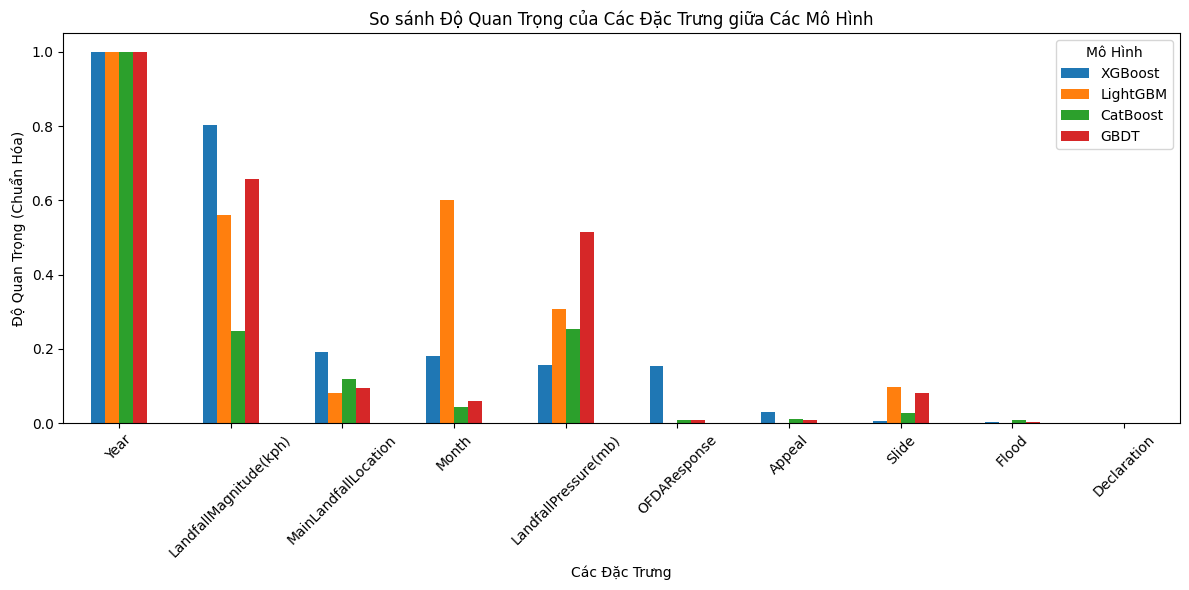

In [214]:
combined_importance.plot(kind='bar', figsize=(12, 6))
plt.title('So sánh Độ Quan Trọng của Các Đặc Trưng giữa Các Mô Hình')
plt.ylabel('Độ Quan Trọng (Chuẩn Hóa)')
plt.xlabel('Các Đặc Trưng')
plt.legend(title='Mô Hình')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 1.3.  Adjusted Damage

In [215]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"LINEAR_TARGETS :{LINEAR_TARGETS[2]}")
print(f"ATTRIBUTES :{ATTRIBUTES + CATEGORICAL_TARGETS}")

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES + CATEGORICAL_TARGETS]
y = slide_df[LINEAR_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

LINEAR_TARGETS :TotalDamageAdjusted(000US$)
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)', 'Flood', 'Slide']
Train size 147
Test size: 37


### 1.3.1 XGBOOST

In [216]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [217]:
feature_names = ATTRIBUTES + CATEGORICAL_TARGETS
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
0                    Year    0.396318
6  LandfallMagnitude(kph)    0.317871
2    MainLandfallLocation    0.075518
1                   Month    0.071624
7    LandfallPressure(mb)    0.062361
3            OFDAResponse    0.060686
4                  Appeal    0.012395
9                   Slide    0.002352
8                   Flood    0.000875
5             Declaration    0.000000


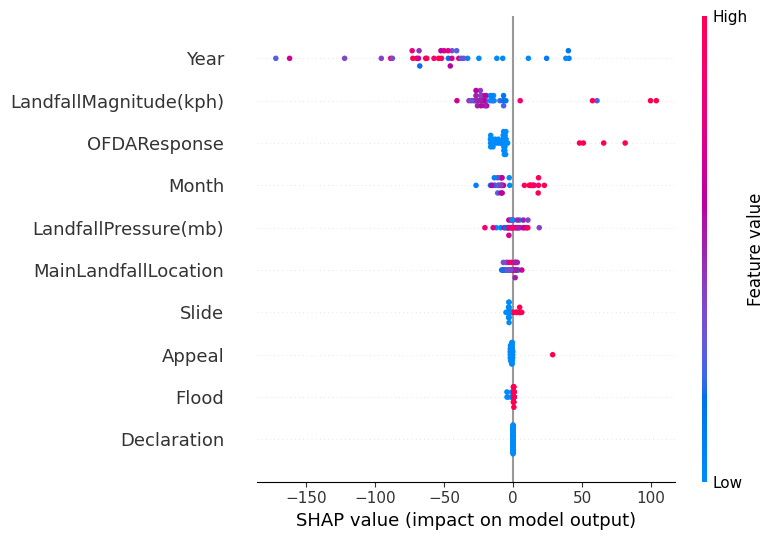

In [218]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.2 LightGBM

In [219]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 107
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 7
[LightGBM] [Info] Start training from score 106.857143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

LGBMRegressor()

In [220]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         173
1                   Month         104
6  LandfallMagnitude(kph)          97
7    LandfallPressure(mb)          53
9                   Slide          17
2    MainLandfallLocation          14
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0
8                   Flood           0


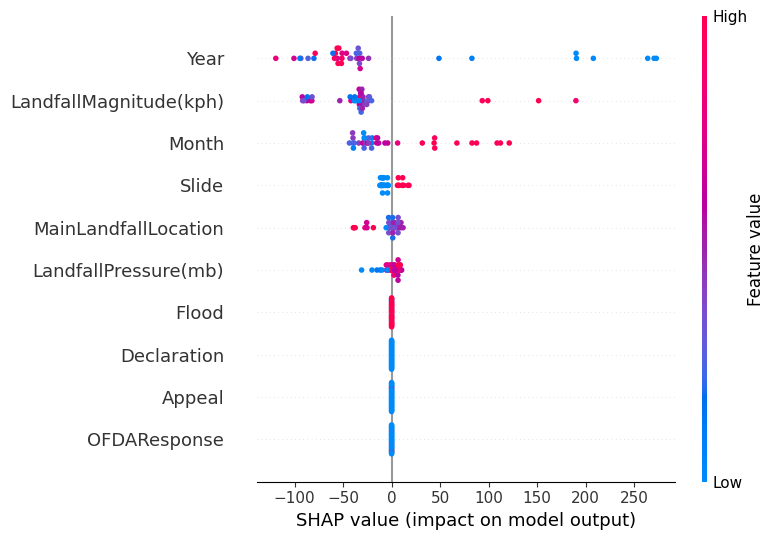

In [221]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.3 CatBoost

In [222]:
# !pip install catboost

In [223]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 474.8935653	total: 496us	remaining: 496ms
1:	learn: 471.3640040	total: 1.25ms	remaining: 622ms
2:	learn: 468.0167703	total: 1.89ms	remaining: 628ms
3:	learn: 464.5655498	total: 2.5ms	remaining: 622ms
4:	learn: 461.0471589	total: 3.21ms	remaining: 638ms
5:	learn: 457.8991406	total: 3.97ms	remaining: 658ms
6:	learn: 454.6768441	total: 4.62ms	remaining: 655ms
7:	learn: 451.5365131	total: 5.48ms	remaining: 679ms
8:	learn: 448.4834973	total: 6.13ms	remaining: 675ms
9:	learn: 445.1840673	total: 6.73ms	remaining: 666ms
10:	learn: 441.9371963	total: 7.37ms	remaining: 663ms
11:	learn: 438.6976759	total: 8.07ms	remaining: 664ms
12:	learn: 435.4896915	total: 8.69ms	remaining: 660ms
13:	learn: 432.2595625	total: 9.32ms	remaining: 656ms
14:	learn: 429.0760846	total: 9.66ms	remaining: 634ms
15:	learn: 426.1680837	total: 10.2ms	remaining: 629ms
16:	learn: 423.0339016	total: 10.8ms	remaining: 627ms
17:	learn: 419.9474727	total: 11.5ms	remaining: 625ms
18:	learn:

In [224]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   58.217045
7    LandfallPressure(mb)   14.813903
6  LandfallMagnitude(kph)   14.499775
2    MainLandfallLocation    6.891082
1                   Month    2.524050
9                   Slide    1.516541
4                  Appeal    0.587349
3            OFDAResponse    0.478096
8                   Flood    0.472158
5             Declaration    0.000000


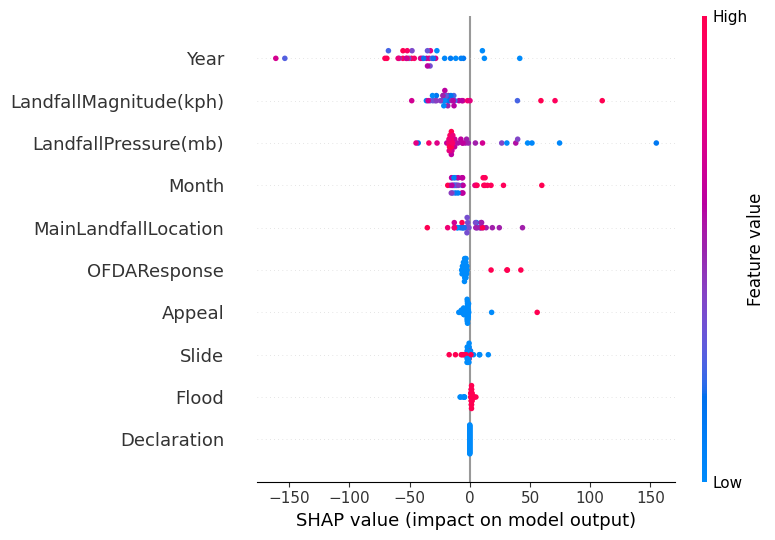

In [225]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 1.3.4 Decision Trees (GBDT)

In [226]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [227]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.412169
7    LandfallPressure(mb)    0.333314
6  LandfallMagnitude(kph)    0.146684
2    MainLandfallLocation    0.062549
9                   Slide    0.027835
1                   Month    0.010348
3            OFDAResponse    0.003277
4                  Appeal    0.003220
8                   Flood    0.000604
5             Declaration    0.000000


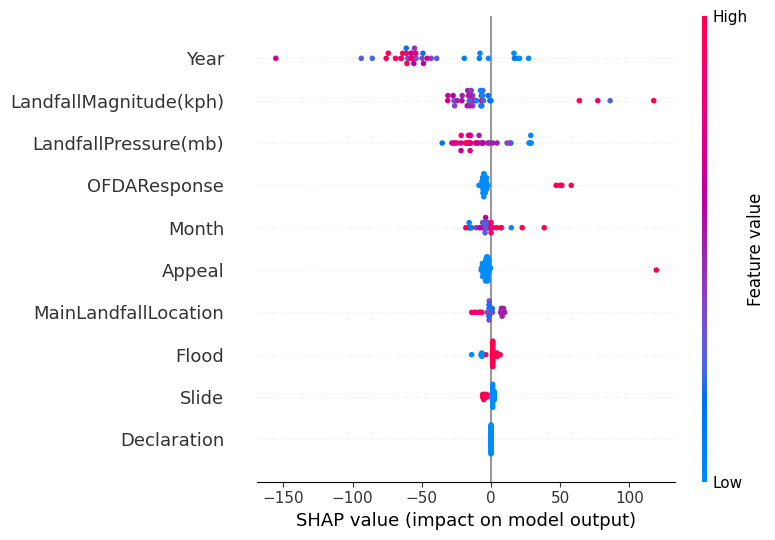

In [228]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 1.3.5 COMPARISION

In [229]:
# Chuẩn hóa độ quan trọng
def normalize_importance(df):
    df['Importance'] = (df['Importance'] - df['Importance'].min()) / (df['Importance'].max() - df['Importance'].min())
    return df

xgb_importance_df = normalize_importance(xgb_importance_df)
lgb_importance_df = normalize_importance(lgb_importance_df)
cat_importance_df = normalize_importance(cat_importance_df)
gbdt_importance_df = normalize_importance(gbdt_importance_df)

In [230]:
combined_importance = pd.concat([
    xgb_importance_df.set_index('Feature').rename(columns={'Importance': 'XGBoost'}),
    lgb_importance_df.set_index('Feature').rename(columns={'Importance': 'LightGBM'}),
    cat_importance_df.set_index('Feature').rename(columns={'Importance': 'CatBoost'}),
    gbdt_importance_df.set_index('Feature').rename(columns={'Importance': 'GBDT'})
], axis=1)

# Thay thế NaN bằng 0
combined_importance = combined_importance.fillna(0)

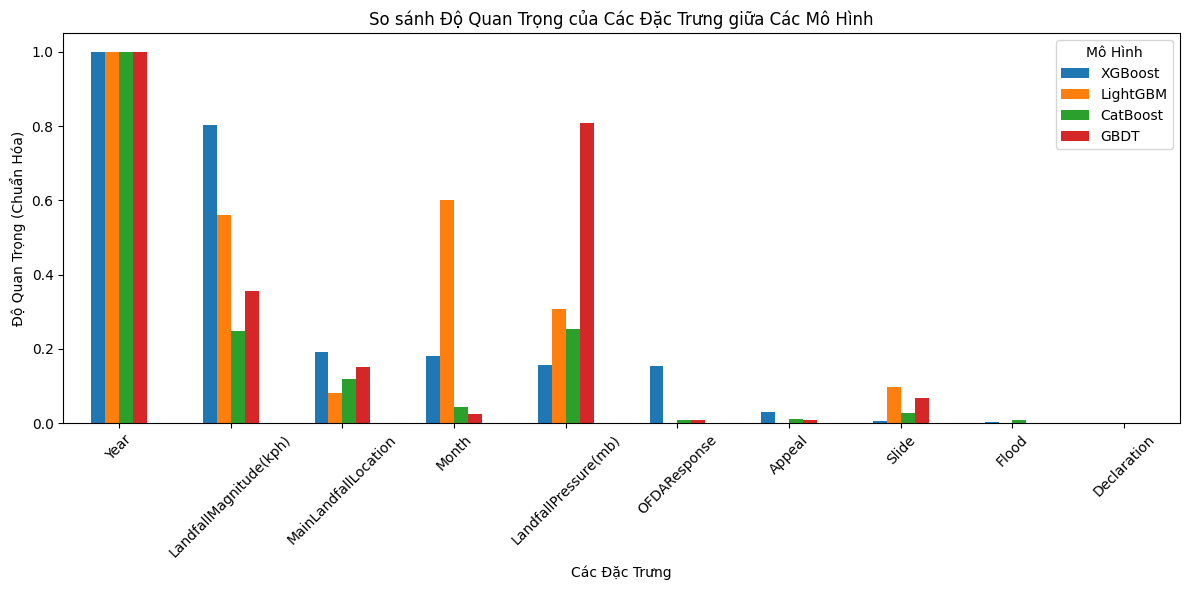

In [231]:
combined_importance.plot(kind='bar', figsize=(12, 6))
plt.title('So sánh Độ Quan Trọng của Các Đặc Trưng giữa Các Mô Hình')
plt.ylabel('Độ Quan Trọng (Chuẩn Hóa)')
plt.xlabel('Các Đặc Trưng')
plt.legend(title='Mô Hình')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. PREDICT CATEGORICAL_TARGET


## 1.1.  Flood

In [240]:
evaluate_dict = dict()

print(f"CATEGORICAL_TARGETS :{CATEGORICAL_TARGETS[0]}")
print(f"ATTRIBUTES :{ATTRIBUTES}")
feature_names = ATTRIBUTES

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES]
y = slide_df[CATEGORICAL_TARGETS[0]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

CATEGORICAL_TARGETS :Flood
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']
Train size 147
Test size: 37


### 2.1.1 XGBOOST

In [241]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [242]:
xgb_importance = xgb_model.feature_importances_

# Create a DataFrame for feature importance
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
1                   Month    0.303616
7    LandfallPressure(mb)    0.263389
0                    Year    0.157937
2    MainLandfallLocation    0.149520
6  LandfallMagnitude(kph)    0.118989
3            OFDAResponse    0.004550
4                  Appeal    0.002000
5             Declaration    0.000000


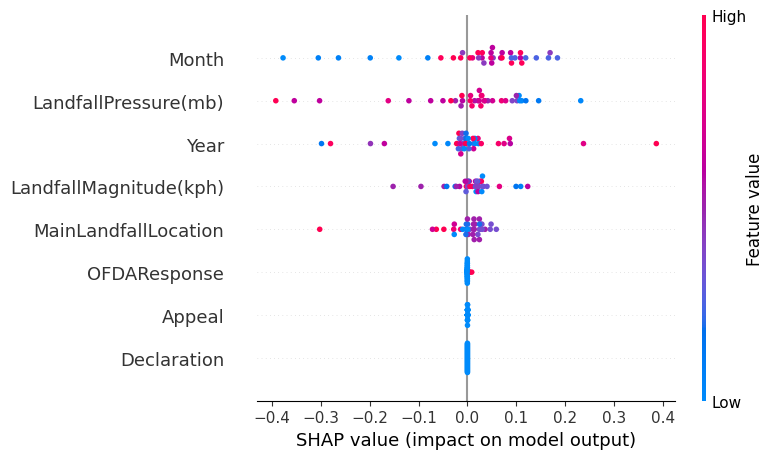

In [243]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.2 LightGBM

In [244]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 5
[LightGBM] [Info] Start training from score 0.829932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [245]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         151
7    LandfallPressure(mb)         100
6  LandfallMagnitude(kph)          99
2    MainLandfallLocation          57
1                   Month          54
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0


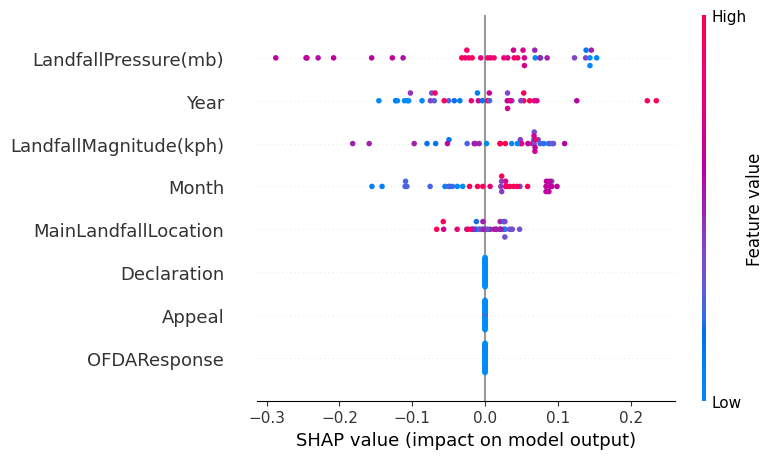

In [246]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.3 CatBoost

In [247]:
# !pip install catboost

In [248]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 0.3736679	total: 431us	remaining: 431ms
1:	learn: 0.3709531	total: 1.1ms	remaining: 547ms
2:	learn: 0.3689776	total: 1.73ms	remaining: 577ms
3:	learn: 0.3669878	total: 2.32ms	remaining: 578ms
4:	learn: 0.3646340	total: 2.88ms	remaining: 574ms
5:	learn: 0.3618291	total: 3.47ms	remaining: 574ms
6:	learn: 0.3585311	total: 4.05ms	remaining: 575ms
7:	learn: 0.3573671	total: 4.43ms	remaining: 549ms
8:	learn: 0.3554138	total: 5.03ms	remaining: 554ms
9:	learn: 0.3525755	total: 5.61ms	remaining: 555ms
10:	learn: 0.3507109	total: 6.16ms	remaining: 554ms
11:	learn: 0.3486745	total: 6.73ms	remaining: 554ms
12:	learn: 0.3462853	total: 7.3ms	remaining: 554ms
13:	learn: 0.3443763	total: 7.85ms	remaining: 553ms
14:	learn: 0.3426802	total: 8.39ms	remaining: 551ms
15:	learn: 0.3408363	total: 8.9ms	remaining: 547ms
16:	learn: 0.3391814	total: 9.45ms	remaining: 546ms
17:	learn: 0.3376704	total: 10ms	remaining: 545ms
18:	learn: 0.3341124	total: 10.6ms	remaining: 545m

In [249]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
1                   Month   24.222477
7    LandfallPressure(mb)   23.301976
0                    Year   22.878854
6  LandfallMagnitude(kph)   16.453045
2    MainLandfallLocation   12.177419
3            OFDAResponse    0.556520
4                  Appeal    0.409709
5             Declaration    0.000000


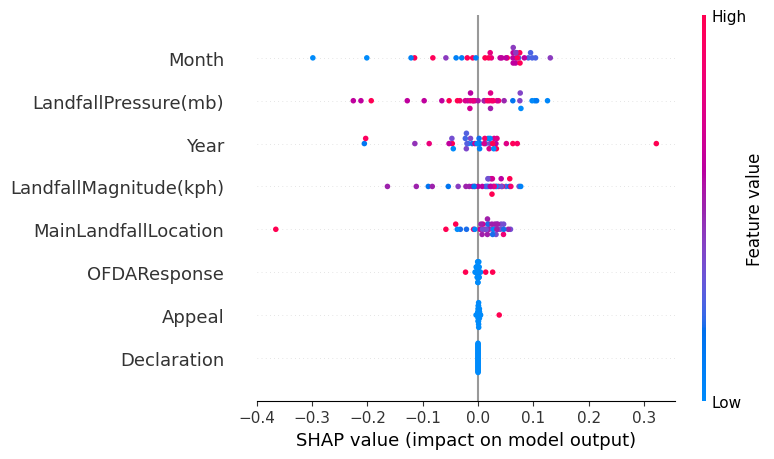

In [250]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.1.4 Decision Trees (GBDT)

In [251]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [252]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
0                    Year    0.365113
1                   Month    0.269123
7    LandfallPressure(mb)    0.178952
6  LandfallMagnitude(kph)    0.113717
2    MainLandfallLocation    0.071976
4                  Appeal    0.001118
3            OFDAResponse    0.000000
5             Declaration    0.000000


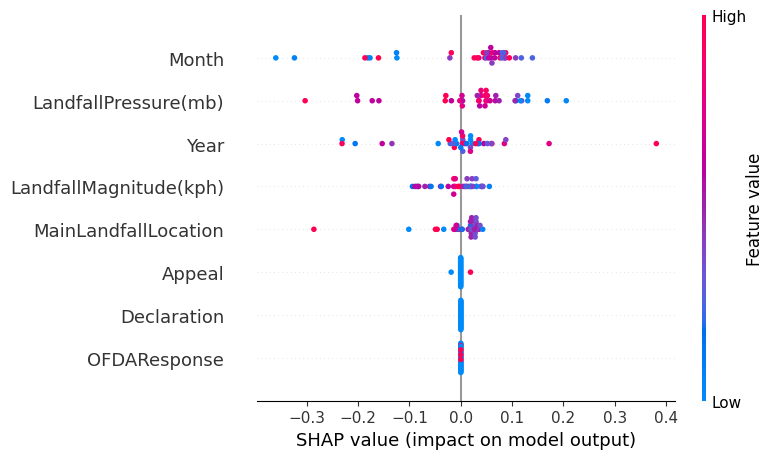

In [253]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 2.1.5 COMPARISION

In [254]:
# Chuẩn hóa độ quan trọng
def normalize_importance(df):
    df['Importance'] = (df['Importance'] - df['Importance'].min()) / (df['Importance'].max() - df['Importance'].min())
    return df

xgb_importance_df = normalize_importance(xgb_importance_df)
lgb_importance_df = normalize_importance(lgb_importance_df)
cat_importance_df = normalize_importance(cat_importance_df)
gbdt_importance_df = normalize_importance(gbdt_importance_df)

In [255]:
combined_importance = pd.concat([
    xgb_importance_df.set_index('Feature').rename(columns={'Importance': 'XGBoost'}),
    lgb_importance_df.set_index('Feature').rename(columns={'Importance': 'LightGBM'}),
    cat_importance_df.set_index('Feature').rename(columns={'Importance': 'CatBoost'}),
    gbdt_importance_df.set_index('Feature').rename(columns={'Importance': 'GBDT'})
], axis=1)

# Thay thế NaN bằng 0
combined_importance = combined_importance.fillna(0)

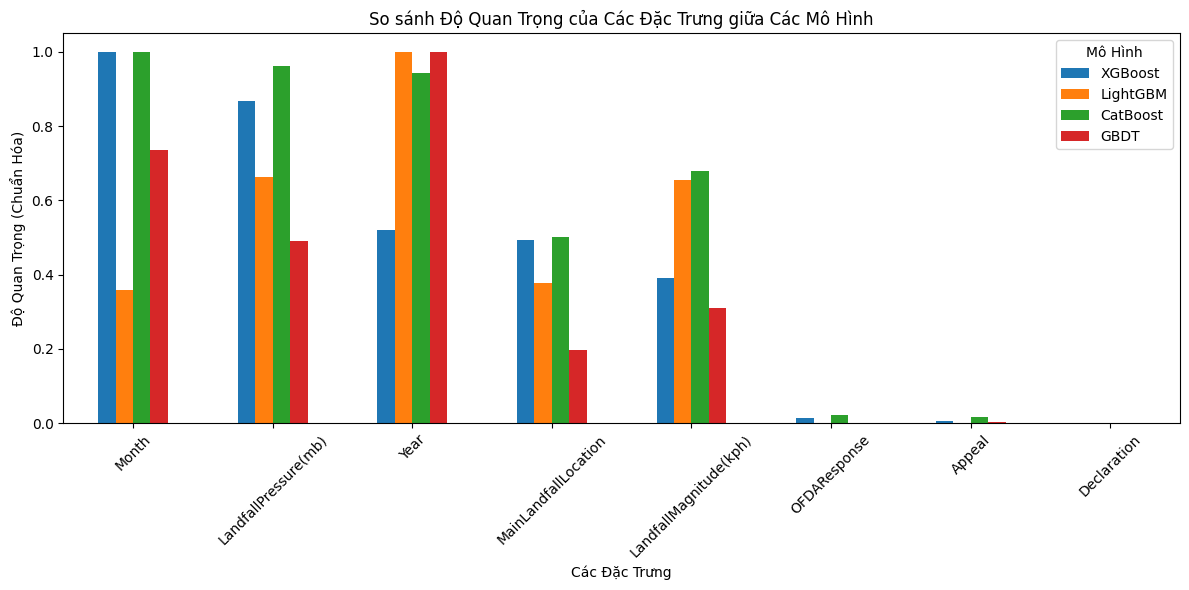

In [256]:
combined_importance.plot(kind='bar', figsize=(12, 6))
plt.title('So sánh Độ Quan Trọng của Các Đặc Trưng giữa Các Mô Hình')
plt.ylabel('Độ Quan Trọng (Chuẩn Hóa)')
plt.xlabel('Các Đặc Trưng')
plt.legend(title='Mô Hình')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 2.2.  Slide

In [257]:
from const import LINEAR_TARGETS

evaluate_dict = dict()

print(f"CATEGORICAL_TARGETS :{CATEGORICAL_TARGETS[1]}")
print(f"ATTRIBUTES :{ATTRIBUTES}")
feature_names = ATTRIBUTES

slide_df = base_df.copy()
X = slide_df[ATTRIBUTES]
y = slide_df[CATEGORICAL_TARGETS[1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size {len(X_train)}")
print(f"Test size: {len(X_test)}")

CATEGORICAL_TARGETS :Slide
ATTRIBUTES :['Year', 'Month', 'MainLandfallLocation', 'OFDAResponse', 'Appeal', 'Declaration', 'LandfallMagnitude(kph)', 'LandfallPressure(mb)']
Train size 147
Test size: 37


### 2.2.1 XGBOOST

In [258]:
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [259]:
xgb_importance = xgb_model.feature_importances_

xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_importance
}).sort_values(by='Importance', ascending=False)
print(xgb_importance_df)


                  Feature  Importance
4                  Appeal    0.329285
3            OFDAResponse    0.148877
7    LandfallPressure(mb)    0.136016
2    MainLandfallLocation    0.111162
6  LandfallMagnitude(kph)    0.103988
0                    Year    0.085556
1                   Month    0.085117
5             Declaration    0.000000


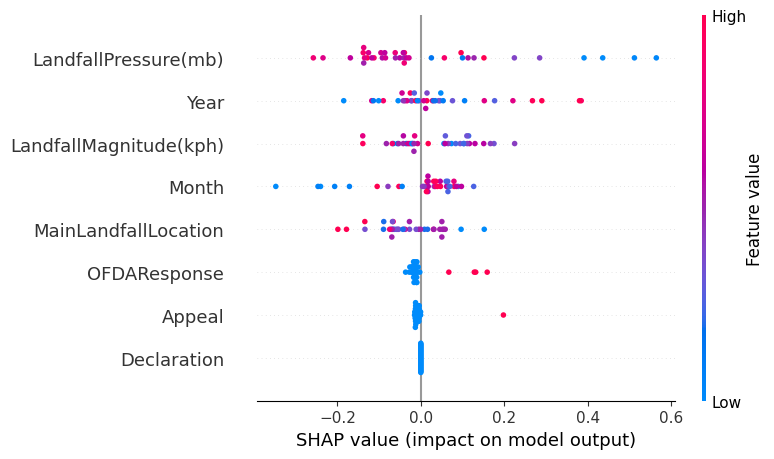

In [260]:
import shap
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.2.2 LightGBM

In [261]:
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 103
[LightGBM] [Info] Number of data points in the train set: 147, number of used features: 5
[LightGBM] [Info] Start training from score 0.374150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor()

In [262]:
lgb_importance = lgb_model.feature_importances_
lgb_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lgb_importance}).sort_values(by='Importance', ascending=False)
print(lgb_importance_df)

                  Feature  Importance
0                    Year         172
6  LandfallMagnitude(kph)          93
2    MainLandfallLocation          66
7    LandfallPressure(mb)          62
1                   Month          56
3            OFDAResponse           0
4                  Appeal           0
5             Declaration           0


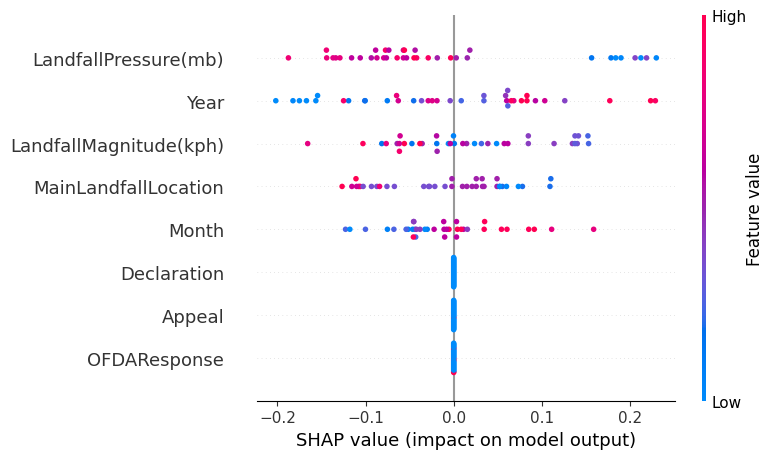

In [263]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 2.2.3 CatBoost

In [264]:
# !pip install catboost

In [265]:
cat_model = CatBoostRegressor()
cat_model.fit(X_train, y_train)

Learning rate set to 0.030242
0:	learn: 0.4832480	total: 398us	remaining: 398ms
1:	learn: 0.4814859	total: 1.08ms	remaining: 541ms
2:	learn: 0.4807739	total: 1.54ms	remaining: 512ms
3:	learn: 0.4801573	total: 2.04ms	remaining: 509ms
4:	learn: 0.4787167	total: 2.65ms	remaining: 528ms
5:	learn: 0.4768916	total: 3.22ms	remaining: 534ms
6:	learn: 0.4749873	total: 3.84ms	remaining: 545ms
7:	learn: 0.4741913	total: 4.42ms	remaining: 548ms
8:	learn: 0.4727953	total: 4.99ms	remaining: 549ms
9:	learn: 0.4712711	total: 5.54ms	remaining: 548ms
10:	learn: 0.4704114	total: 6.12ms	remaining: 550ms
11:	learn: 0.4685792	total: 7.12ms	remaining: 586ms
12:	learn: 0.4670738	total: 7.73ms	remaining: 587ms
13:	learn: 0.4659621	total: 8.31ms	remaining: 585ms
14:	learn: 0.4642665	total: 8.9ms	remaining: 584ms
15:	learn: 0.4630175	total: 9.51ms	remaining: 585ms
16:	learn: 0.4614651	total: 10.1ms	remaining: 582ms
17:	learn: 0.4595074	total: 10.9ms	remaining: 596ms
18:	learn: 0.4589035	total: 11.5ms	remaining: 

In [266]:
cat_importance = cat_model.feature_importances_
cat_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': cat_importance}).sort_values(by='Importance', ascending=False)
print(cat_importance_df)

                  Feature  Importance
0                    Year   26.783603
7    LandfallPressure(mb)   23.833091
6  LandfallMagnitude(kph)   17.130593
2    MainLandfallLocation   16.186391
1                   Month   12.403057
3            OFDAResponse    1.994169
4                  Appeal    1.669096
5             Declaration    0.000000


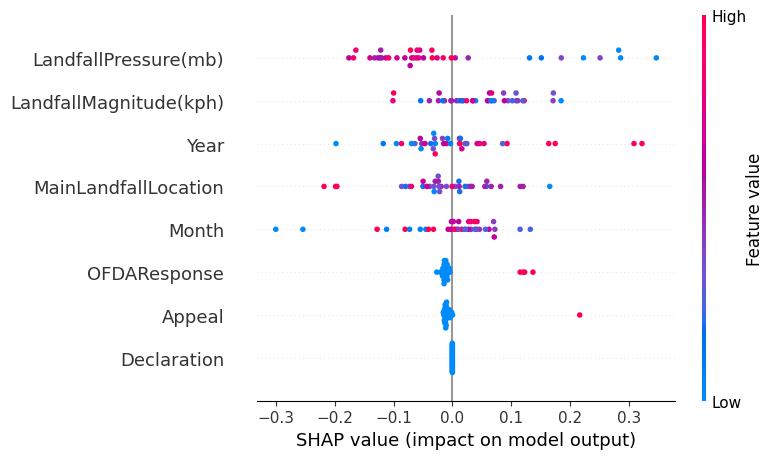

In [267]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)


### 2.2.4 Decision Trees (GBDT)

In [268]:
gbdt_model = GradientBoostingRegressor().fit(X_train, y_train)

In [269]:
gbdt_importance = gbdt_model.feature_importances_
gbdt_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': gbdt_importance}).sort_values(by='Importance', ascending=False)
print(gbdt_importance_df)

                  Feature  Importance
7    LandfallPressure(mb)    0.306173
0                    Year    0.235798
6  LandfallMagnitude(kph)    0.184229
1                   Month    0.134758
2    MainLandfallLocation    0.079976
4                  Appeal    0.041846
3            OFDAResponse    0.017220
5             Declaration    0.000000


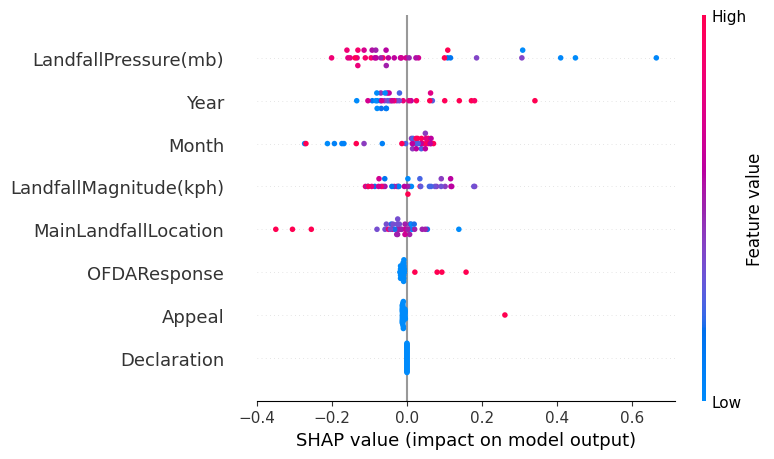

In [270]:
explainer = shap.TreeExplainer(gbdt_model)
shap_values = explainer.shap_values(X_test)

# Plot the feature importance
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

### 2.2.5 COMPARISION

In [271]:
# Chuẩn hóa độ quan trọng
def normalize_importance(df):
    df['Importance'] = (df['Importance'] - df['Importance'].min()) / (df['Importance'].max() - df['Importance'].min())
    return df

xgb_importance_df = normalize_importance(xgb_importance_df)
lgb_importance_df = normalize_importance(lgb_importance_df)
cat_importance_df = normalize_importance(cat_importance_df)
gbdt_importance_df = normalize_importance(gbdt_importance_df)

In [272]:
combined_importance = pd.concat([
    xgb_importance_df.set_index('Feature').rename(columns={'Importance': 'XGBoost'}),
    lgb_importance_df.set_index('Feature').rename(columns={'Importance': 'LightGBM'}),
    cat_importance_df.set_index('Feature').rename(columns={'Importance': 'CatBoost'}),
    gbdt_importance_df.set_index('Feature').rename(columns={'Importance': 'GBDT'})
], axis=1)

# Thay thế NaN bằng 0
combined_importance = combined_importance.fillna(0)

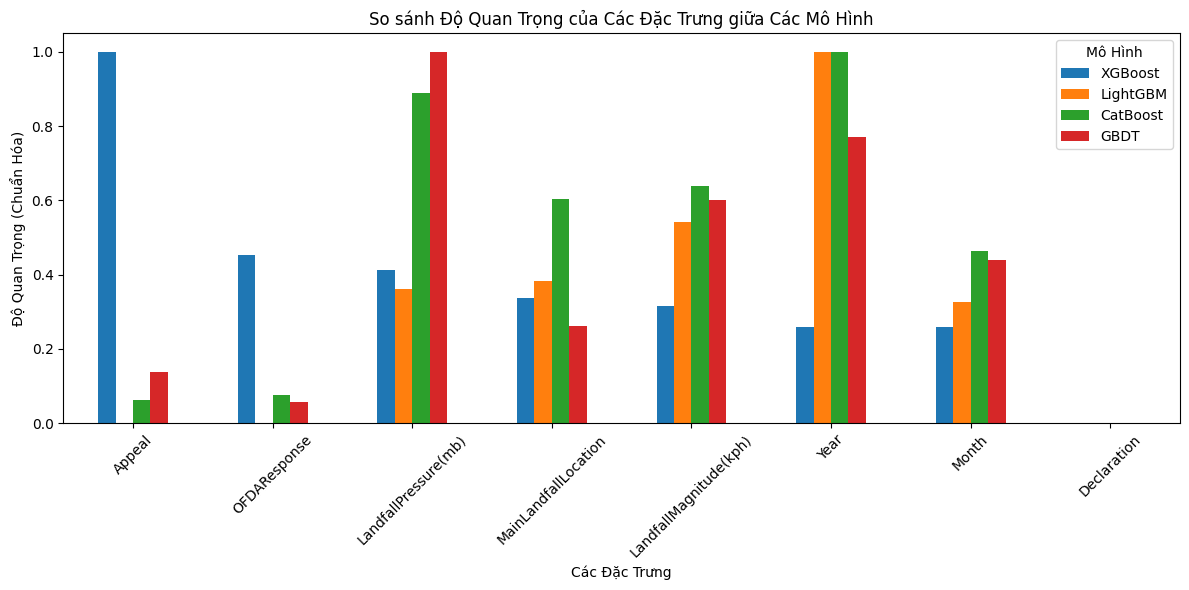

In [273]:
combined_importance.plot(kind='bar', figsize=(12, 6))
plt.title('So sánh Độ Quan Trọng của Các Đặc Trưng giữa Các Mô Hình')
plt.ylabel('Độ Quan Trọng (Chuẩn Hóa)')
plt.xlabel('Các Đặc Trưng')
plt.legend(title='Mô Hình')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()